# Movie or StackOverflow?

The aim of this is a binary classifier. Given an unseen set of statements and correctly decipher if they are movie questions or stackoverflow posts

## Libraries

### Colaboratory Specific Code

This mounts your Google Drive folder so you can access it from Colaboratory

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


We also want to change the working directory so that the file references work. Here I've places the files for this class inside a folder called 'class_1' that itself is inside a folder called 'NLP_class'.

In [0]:
%cd drive/My\ Drive/NLP_class/0719_question
!ls

/content/drive/My Drive/NLP_class/0719_question
 dialogues.tsv			 Question_hw_stackoverflow.ipynb
 July_2019_NLP_Questions.ipynb	 Solution_hw_stackoverflow.ipynb
 Movie_or_StackOverflow.ipynb	 tagged_posts.tsv
'NLP Additional Exercise.docx'	 tfidf_vectorizer.pkl
'NLP class.ipynb'		 training_1
 q1				 utils.py
 q2				 Which_Language.ipynb


In [0]:
!pip install scikit-plot

### Dependencies

In [0]:
import pandas as pd
from sklearn.utils import shuffle
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import os

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow.keras as keras

# Metrics
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
import scikitplot as skplt
from scikitplot.metrics import plot_confusion_matrix

# Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD

# Saving models
import _pickle as pickle

# PLotting
import plotly.offline as plt
plt.init_notebook_mode(connected=True)

np.random.seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(n_splits=5, random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    plot_confusion_matrix(y, preds)
    
    return preds


## Define Models

Change LOAD_MODELS to 1 to load saved models from file

In [0]:
LOAD_MODELS = 1

In [0]:
if LOAD_MODELS == 0:
    print("Program will train new models")
    # CSR Set
    linr = linear_model.LinearRegression(n_jobs = -1)

    lr = linear_model.LogisticRegression(C=10.0, penalty='l2', solver = 'newton-cg', n_jobs=-1, multi_class='auto')

    rf = RandomForestClassifier(criterion='gini', max_depth=5, 
                                   min_samples_leaf=5, min_samples_split=2, 
                                   n_estimators = 220, oob_score=True, 
                                   max_features=0.5, n_jobs = -1, random_state=42)

    # Dimension Reduced Set
    nb_sv = GaussianNB()

    linr_sv = linear_model.LinearRegression(n_jobs = -1)

    lr_sv = linear_model.LogisticRegression(C=10.0, penalty='l2', solver = 'newton-cg', n_jobs=-1, multi_class='auto')

    rf_sv = RandomForestClassifier(criterion='gini', max_depth=5, 
                                   min_samples_leaf=5, min_samples_split=2, 
                                   n_estimators = 220, oob_score=True, 
                                   max_features=0.5, n_jobs = -1, random_state=42)
else:
    print("Program will load existing models if available")

    linr = pickle.load( open( "q1/linr.p", "rb" ) )
    lr = pickle.load( open( "q1/lr.p", "rb" ) )
    rf = pickle.load( open( "q1/rf.p", "rb" ) )
    
    nb_sv = pickle.load( open( "q1/nb_sv.p", "rb" ) )
    linr_sv = pickle.load( open( "q1/linr_sv.p", "rb" ) )
    lr_sv = pickle.load( open( "q1/lr_sv.p", "rb" ) )
    rf_sv = pickle.load( open( "q1/rf_sv.p", "rb" ) )
    

Program will load existing models if available


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning:

Trying to unpickle estimator LinearRegression from version 0.20.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning:

Trying to unpickle estimator LogisticRegression from version 0.20.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 0.20.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning:

Trying to unpickle estimator RandomForestClassifier from version 0.20.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.

/usr/local/lib

## Pre-process the data

This code cleans the text

In [0]:
# There is a problem with this codes as it is possible for all words to be removed leaving a null value
# This is solved in line 25 with the if statement

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE, "", text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " " + text + " "
    for sw in STOPWORDS:
        text = text.replace(" "+sw+" ", " ") # delete stopwords from text
    text = re.sub('[ ][ ]+', " ", text)

    #     print("text:", text)
#     print(len(text))
    
    if len(text) > 1: # only run if there are words present
      if text[0] == ' ':
          text = text[1:]
      if text[-1] == ' ':
          text = text[:-1]
        
    return text

### Inspect Data
Let's see what the data looks like

In [0]:
dialogues = pd.read_csv('dialogues.tsv', sep='\t')
tagged = pd.read_csv('tagged_posts.tsv', sep='\t')

In [0]:
dialogues.head(2)

,text,tag
0,Okay -- you're gonna need to learn how to lie.,dialogue
1,I'm kidding. You know how sometimes you just ...,dialogue


In [0]:
tagged.head(2)

,post_id,title,tag
0,9,Calculate age in C#,c#
1,16,Filling a DataSet or DataTable from a LINQ que...,c#


### Create base dataset

Now we can drop the 'tag' columns of both and assign new labels. 

We set a movie question to label 0 and a stack overflow post to label 1

We also need to drop the 'post_id' column of the stack overflow data and rename 'title' to 'text'

In [0]:
movie = dialogues.drop(columns=['tag'])
movie['label'] = int(0)
movie.head(2)

,text,label
0,Okay -- you're gonna need to learn how to lie.,0
1,I'm kidding. You know how sometimes you just ...,0


In [0]:
stack = tagged.drop(columns=['post_id','tag'])
stack['label'] = int(1)
stack = stack.rename(columns={"title": "text"})
stack.head(2)

,text,label
0,Calculate age in C#,1
1,Filling a DataSet or DataTable from a LINQ que...,1


We now combine the two different data sets into one single data set.

In [0]:
data = movie.append(stack, ignore_index=True)
data.head()

,text,label
0,Okay -- you're gonna need to learn how to lie.,0
1,I'm kidding. You know how sometimes you just ...,0
2,Like my fear of wearing pastels?,0
3,I figured you'd get to the good stuff eventually.,0
4,Thank God! If I had to hear one more story ab...,0


### Clean the text

In [0]:
data.shape

(615477, 2)

Here we can see that certain lines are entirely made up of stopwords and symbols. We need to account for this.

In [0]:
print("This line: ", data.loc[82457, 'text'])
print("\nBecomes: ", text_prepare(data.loc[82457, 'text']))

This line:  Do you have to do that?

Becomes:  do


Now we run the cleaning function on the whole database.

In [0]:
%time cleaned_text = [text_prepare(x) for x in data['text']]

CPU times: user 46 s, sys: 106 ms, total: 46.1 s
Wall time: 46.2 s


In [0]:
clean_text = pd.DataFrame({'clean_data': cleaned_text})
clean_text.head()

,clean_data
0,okay youre gonna need learn lie
1,im kidding know sometimes become persona dont ...
2,like fear wearing pastels
3,figured youd get good stuff eventually
4,thank god hear one story coiffure


In [0]:
clean = pd.concat([clean_text, data], axis = 1, ignore_index=True)
clean = shuffle(clean)
clean.head()

,0,1,2
378098,syntax error insert statement c# oledb,Syntax error in INSERT INTO statement in c# ol...,1
274212,applying methods object private variables java...,applying methods to object and private variabl...,1
527013,xampp openssl errors calling openssl_pkey_new,xampp openssl errors when calling openssl_pkey...,1
25072,let buyer beware,Let the buyer beware.,0
491370,read write locking confusion,Read/Write locking confusion,1


In [0]:
clean = clean.drop(columns=[1])
clean.head(5)

,0,2
378098,syntax error insert statement c# oledb,1
274212,applying methods object private variables java...,1
527013,xampp openssl errors calling openssl_pkey_new,1
25072,let buyer beware,0
491370,read write locking confusion,1


Check that there are only 2 labels (binary) and see the amount of each.

In [0]:
unique_labels = clean.groupby(2).nunique()
unique_labels.head()

,0,2
2,,
0,206952,1
1,394520,1


### Train Test Validation Split

In [0]:
clean_data = clean[0]
clean_data.head()

378098               syntax error insert statement c# oledb
274212    applying methods object private variables java...
527013        xampp openssl errors calling openssl_pkey_new
25072                                      let buyer beware
491370                         read write locking confusion
Name: 0, dtype: object

In [0]:
clean_labels = clean[2]
clean_labels.head()

378098    1
274212    1
527013    1
25072     0
491370    1
Name: 2, dtype: int64

First we split off the validation set as 20% of the overall data set.

In [0]:
df_data, X_val, df_labels, y_val = train_test_split(
    clean_data, clean_labels, test_size=0.2, random_state=42, shuffle=False)

Then we split the remaining into training and test data.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.25,
                                                        random_state=42,
                                                        shuffle=False)

The end result is 60% training data, 20% test data and 20% validation data

In [0]:
print("Shape of X_train", X_train.shape)
print("Shape of y_train", X_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)
print("Shape of X_val", X_val.shape)
print("Shape of y_val", y_val.shape)

Shape of X_train (369285,)
Shape of y_train (369285,)
Shape of X_test (123096,)
Shape of y_test (123096,)
Shape of X_val (123096,)
Shape of y_val (123096,)


### Apply TF-IDF Weighting

We first need to learn the words for the dictionary from our training data.

In [0]:
vectorizer = TfidfVectorizer(norm=u'l1', token_pattern='(\S+)', min_df=5, max_df=0.9, ngram_range=(1,2))

%time vectorizer.fit_transform(X_train)
# print(vectorizer.get_feature_names(10))

CPU times: user 11.7 s, sys: 386 ms, total: 12.1 s
Wall time: 12.1 s


<369285x65391 sparse matrix of type '<class 'numpy.float64'>'
	with 2693516 stored elements in Compressed Sparse Row format>

Apply this learned TF-IDF transform to our different dataframes

In [0]:
%time train_tf = vectorizer.transform(X_train)
# train_tf = csr_matrix.mean(train_tf, axis=0)

%time test_tf = vectorizer.transform(X_test)
# test_tf = csr_matrix.mean(test_tf, axis=0)

%time val_tf = vectorizer.transform(X_val)
# val_tf = csr_matrix.mean(val_tf, axis=0)

CPU times: user 6.03 s, sys: 6.94 ms, total: 6.04 s
Wall time: 6.04 s
CPU times: user 2.01 s, sys: 962 µs, total: 2.01 s
Wall time: 2.01 s
CPU times: user 2.02 s, sys: 3.96 ms, total: 2.03 s
Wall time: 2.03 s


We can see that the different dataframes have been transformed intt Compressed Sparse Row format data. This is very important as sparsity has a big impact on accuracy.

In [0]:
print("Shape of train_tf", train_tf.shape)

print("Shape of test_tf", test_tf.shape)

print("Shape of val_tf", val_tf.shape)

Shape of train_tf (369285, 65391)
Shape of test_tf (123096, 65391)
Shape of val_tf (123096, 65391)


In [0]:
true_label = y_test.values

## Classify CSR

First we will attempt to classify the full CSR dataset

### Naive Bayes
Interestingly this crashes and causes the runtime to reset as the dimensionality is too high.

In [0]:
# nb = GaussianNB()
# nb.fit(train_tf.todense(), y_train.astype(int))

In [0]:
# nb_score_test = nb.score(test_tf.todense(), y_test.astype(int))
# nb_score_test

### Linear Regression

In [0]:
if LOAD_MODELS == 0:
    %time linr.fit(train_tf, y_train.astype(int))

In [0]:
# %time linr_score_test = linr.score(test_tf, y_test.astype(int))
# print(linr_score_test*100

In [0]:
%time scores = cross_val_score(linr, test_tf, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

CPU times: user 4min 36s, sys: 3min 3s, total: 7min 40s
Wall time: 3min 53s
Accuracy: 0.81 (+/- 0.01)


We don't have a confusion matrix for the LR as it returns continuous results not discrete ones

### Logistic Regression

In [0]:
if LOAD_MODELS == 0:
    %time lr.fit(train_tf, y_train)

In [0]:
# %time lr_score_test = lr.score(test_tf, y_test.astype(int))
# print(lr_score_test*100)
# %time scores = cross_val_score(lr, test_tf, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

We can better understand the accuracy by looking at a confusion matrix




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.1s remaining:    0.0s


Log loss: 0.071055437863347
Accuracy: 0.9843942938844479


array([1, 1, 1, ..., 1, 0, 1])

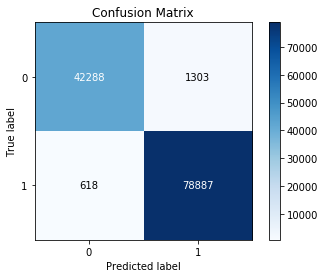

In [0]:
evaluate_features(test_tf, y_test, lr)

### Support Vector Machine
The high dimensionality means that this takes a ridiculous amount of time to run.

In [0]:
# clf = svm.SVC(kernel='linear', C=1, random_state=42)
# %time clf.fit(train_tf, y_train.astype(int))

In [0]:
# %time clf_score = clf.score(test_tf, y_test.astype(int))
# print("SVM accuracy on test:\t %f" % clf_score)

### Random Forest
The high dimensionality means that this takes a ridiculous amount of time to run.

In [0]:
if LOAD_MODELS == 0:
    %time rf.fit(train_tf, y_train.astype(int))

In [0]:
# %time rf_score = rf.score(test_tf, y_test.astype(int))
# print("RF accuracy on test:\t %f" % rf_score)
# %time scores = cross_val_score(rf, test_tf, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 37.0min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 37.0min remaining:    0.0s


Log loss: 0.5383838058832735
Accuracy: 0.752445245986872


array([1, 1, 1, ..., 1, 0, 1])

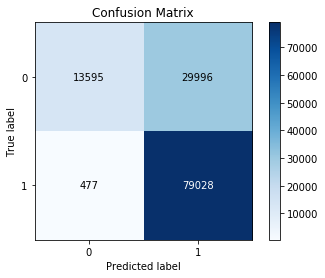

In [0]:
evaluate_features(test_tf, y_test, rf)

We could use a gridsearch to find optimal paramters for a classifier

In [0]:
# rf_grid = RandomForestClassifier(random_state=42)

# param_grid = { 
#     'n_estimators': [100, 120, 140, 160, 180, 200, 220, 240, 260],
#     'min_samples_leaf': [3, 5, 7],
#     'min_samples_split': [2, 3, 4, 5, 6],
#     'max_depth' : [5, 10, 15, 20, 25, 30, 35, 40, 45],
#     'criterion' :['gini', 'entropy']
# }


# CV_rf = GridSearchCV(estimator=rf_grid, param_grid=param_grid, cv= 5, n_jobs = -1, 
#                      verbose = 2)
# CV_rf.fit(train_tf, y_train.astype(int))
# CV_rf.best_params_

## Scores on CSR Validation Set

In [0]:
# nb_score_val = nb.score(val_tf.todense(), y_val.astype(int))
# nb_score_val

In [0]:
# linr_score_val = linr.score(val_tf, y_val)
# linr_score_val
%time scores = cross_val_score(linr, val_tf, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

CPU times: user 4min 45s, sys: 3min 8s, total: 7min 53s
Wall time: 3min 59s
Accuracy: 0.80 (+/- 0.01)


In [0]:
# lr_score_val = lr.score(val_tf, y_val.astype(int))
# lr_score_val
%time scores = cross_val_score(lr, val_tf, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

CPU times: user 220 ms, sys: 97.3 ms, total: 317 ms
Wall time: 12.2 s
Accuracy: 0.98 (+/- 0.00)


In [0]:
# clf_score_val = clf.score(X_val, y_val.astype(int))
# clf_score_val

In [0]:
# rf_score_val = rf.score(val_tf, y_val.astype(int))
# rf_score_val
%time scores = cross_val_score(rf, val_tf, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

CPU times: user 21.1 s, sys: 1.1 s, total: 22.2 s
Wall time: 36min 59s
Accuracy: 0.75 (+/- 0.00)


## Classify Reduced
We will now reduce the dimensionality of the dataset and rety classification.

### Reduce Dimensions using SVD

In [0]:
NUM_DIMEN = 50
svd = TruncatedSVD(n_components=NUM_DIMEN)

In [0]:
%time train_sv = svd.fit_transform(train_tf)
var = svd.explained_variance_.sum() * 100
print("Training data variance with %d SVD components is %f" % (NUM_DIMEN, var))

CPU times: user 23.5 s, sys: 2.78 s, total: 26.3 s
Wall time: 19.9 s
Training data variance with 50 SVD components is 1.630021


In [0]:
%time test_sv = svd.fit_transform(test_tf)
%time val_sv = svd.fit_transform(val_tf)

CPU times: user 7.42 s, sys: 1.67 s, total: 9.08 s
Wall time: 5.76 s
CPU times: user 7.66 s, sys: 1.68 s, total: 9.34 s
Wall time: 5.85 s


In [0]:
print("Shape of train_sv", train_sv.shape)

print("Shape of test_sv", test_sv.shape)

print("Shape of val_sv", val_sv.shape)

Shape of train_sv (369285, 50)
Shape of test_sv (123096, 50)
Shape of val_sv (123096, 50)


### Naive Bayes
With the reduced dimensionality we can use a Naive Bayes classifier

In [0]:
if LOAD_MODELS == 0:
    %time nb_sv.fit(train_sv, y_train.astype(int))

In [0]:
# %time nb_score_test_sv = nb_sv.score(test_sv, y_test.astype(int))
# nb_score_test_sv*100
# %time scores = cross_val_score(nb_sv, test_sv, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Log loss: 2.1457622927390254
Accuracy: 0.8070367842984337


array([1, 1, 1, ..., 1, 0, 1])

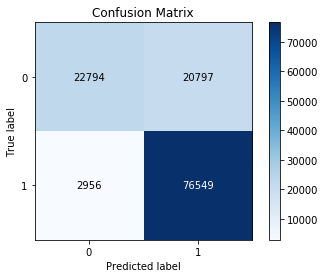

In [0]:
evaluate_features(test_sv, y_test, nb_sv)

### Linear Regression

In [0]:
if LOAD_MODELS == 0:
    %time linr_sv.fit(train_sv, y_train.astype(int))

In [0]:
# %time linr_score_test_sv = linr_sv.score(test_sv, y_test.astype(int))
# linr_score_test_sv*100

In [0]:
%time scores = cross_val_score(linr_sv, test_sv, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

CPU times: user 2.44 s, sys: 596 ms, total: 3.04 s
Wall time: 1.67 s
Accuracy: 0.51 (+/- 0.01)


We don't have a confusion matrix for the LR as it returns continuous results not discrete ones

### Logistic Regression

In [0]:
if LOAD_MODELS == 0:
    %time lr_sv.fit(train_sv, y_train.values)

In [0]:
# %time lr_score_test_sv = lr_sv.score(test_sv, true_label)
# print("Accuracy: ", lr_score_test_sv)
# %time scores = cross_val_score(lr_sv, test_sv, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

We can better understand the accuracy by looking at a confusion matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.6s finished


Log loss: 0.1595209361170267
Accuracy: 0.9629476181191915


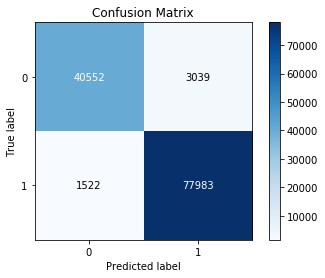

In [0]:
preds = evaluate_features(test_sv, true_label, lr_sv)

Explore the predictions compared to actual labels

In [0]:
# Match is 'True' when values are the same
match = [preds[x] == true_label[x] for x in range(len(preds))]

# Combine and show
df_compare = pd.DataFrame({'Predictions': preds, 'Actual': true_label, 
                           'Match': match})

print('Show performance on first 5 rows')
df_compare.head(10)

Show performance on first 5 rows


,Predictions,Actual,Match
0,1,1,True
1,1,1,True
2,1,1,True
3,1,1,True
4,0,0,True
5,0,0,True
6,0,0,True
7,1,1,True
8,1,1,True
9,1,1,True


### Support Vector Machine
Even at low dimension this takes a lot of time to run.

In [0]:
# clf_sv = svm.SVC(kernel='linear', C=1, random_state=42)
# %time clf_sv.fit(train_sv, y_train.astype(int))

In [0]:
# %time clf_score_sv = clf_sv.score(test_sv, y_test.astype(int))
# print("SVM accuracy on test:\t %f" % clf_score_sv)

### Random Forest

In [0]:
if LOAD_MODELS == 0:
    %time rf_sv.fit(train_sv, y_train.astype(int))

In [0]:
# %time rf_score_sv = rf_sv.score(test_sv, y_test.astype(int))
# print("RF accuracy on test:\t %f" % rf_score_sv)
# %time scores = cross_val_score(rf_sv, test_sv, true_label, cv=StratifiedKFold(n_splits=5, random_state=42))
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.8min finished


Log loss: 0.10757260402623227
Accuracy: 0.9638249821277702


array([1, 1, 1, ..., 1, 0, 1])

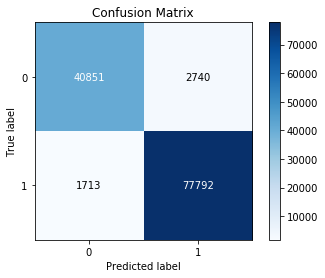

In [0]:
evaluate_features(test_sv, true_label, rf_sv)

### Neural Network

In [0]:
NUM_CLASSES = 10

In [0]:
class EpochTrack(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

def plot_history(history):
    # Define each data series
    trace1 = go.Scatter(x=history.epoch, y=np.array
                        (history.history['mean_absolute_error']), 
                        name='Training Loss')
    trace2 = go.Scatter(x=history.epoch, y=np.array
                        (history.history['val_mean_absolute_error']), 
                        name='Val Loss')

    # Add each series
    data = [trace1, trace2]

    # Define graph layout
    layout = go.Layout(
        title='Training History',
        xaxis=dict(title='Epoch'),
        yaxis=dict(title='Mean Abs Error'))

    fig = go.Figure(data=data, layout=layout)
    plt.iplot(fig)
    
def eval_model(model, test_data, test_labels, VERBOSE, NUM_CLASSES):
    test_labels_sparse = keras.utils.to_categorical(test_labels, NUM_CLASSES)
    [loss, mae, acc] = model.evaluate(test_data, test_labels_sparse, 
                                      verbose=VERBOSE)
    
    print("Mean Abs Error:\t{:7.2f}".format(mae * 1000))
    print("Loss:\t\t", loss)
    print("Accuracy:\t", acc)

    preds = model.predict(test_data)
    y_preds = preds.argmax(axis=-1)
    print(classification_report(test_labels, y_preds))

    return acc, preds
  

In [0]:
def build_mlp(input, NUM_CLASSES):
    model = keras.Sequential([
        keras.layers.Dense(8, activation='relu', input_shape=(input.shape[1],)),
        keras.layers.Dense(5, activation='relu'),
#         keras.layers.Dense(3, activation='relu'),
        keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    learning_rate = 0.001
    optimiser = tf.train.AdamOptimizer(learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=optimiser, 
                  metrics=['mae', 'acc'])

    model.summary()

    return model


def train_mlp(dataframe, labels, model, checkpoint_path, EPOCHS):
    # Limit the training when there are multiple epochs with little change loss
    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=20)

    # Create checkpoint callback
    cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=0)

    # Track the training statistics
    history = model.fit(dataframe, labels, epochs=EPOCHS,
                        validation_split=0.2, verbose=0,
                        callbacks=[early_stop, EpochTrack(), cp_callback])

    print("\nEpochs: {}".format(len(history.epoch)))
    plot_history(history)

    return model

In [0]:
y_train_sparse = keras.utils.to_categorical(y_train, NUM_CLASSES)

TRAIN = 1

if TRAIN == 1:
    checkpoint_path = "training_1/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Train MLP and save to checkpoints
    %time mlp = train_mlp(train_sv, y_train_sparse, build_mlp(train_sv, NUM_CLASSES), checkpoint_path, EPOCHS=2000)
    
else:
    checkpoint_path = "training_1/cp.ckpt"
        
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Load trained weights from the checkpoint path
    mlp = build_mlp(X_train, NUM_CLASSES)
    mlp.load_weights(checkpoint_path)

# Test
print("\nMLP - Test set")
acc_test, preds_test = eval_model(mlp, test_sv, y_test, 0, NUM_CLASSES)

print("\nMLP - Validation set")
acc_val, preds_val = eval_model(mlp, val_sv, y_val, 0, NUM_CLASSES)

W0712 13:26:44.352609 140511647987584 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                60        
Total params: 2,865
Trainable params: 2,865
Non-trainable params: 0
_________________________________________________________________

....................................................................................................
....................................................................................................
....................................................................................................
................................................................................

In [0]:
train_sv.shape

## Scores on Reduced Validation Set

In [0]:
%time scores = cross_val_score(nb_sv, val_sv, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [0]:
%time scores = cross_val_score(linr_sv, val_sv, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [0]:
%time scores = cross_val_score(lr_sv, val_sv, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [0]:
# clf_score_val = clf.score(X_val, y_val.astype(int))
# clf_score_val

In [0]:
%time scores = cross_val_score(rf_sv, val_sv, y_val, cv=StratifiedKFold(n_splits=5, random_state=42))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

## Let's Save Everything

In [0]:
if LOAD_MODELS == 0:    
    pickle.dump( linr, open( "q1/linr.p", "wb" ) )
    pickle.dump( lr, open( "q1/lr.p", "wb" ) )
    pickle.dump( rf, open( "q1/rf.p", "wb" ) )

    pickle.dump( nb_sv, open( "q1/nb_sv.p", "wb" ) )
    pickle.dump( linr_sv, open( "q1/linr_sv.p", "wb" ) )
    pickle.dump( lr_sv, open( "q1/lr_sv.p", "wb" ) )
    pickle.dump( rf_sv, open( "q1/rf_sv.p", "wb" ) )
    pickle.dump( mlp, open( "q1/mlp.p", "wb" ) )
    
print("Done!")

# Further Work

https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm